In [ ]:
import gensim.downloader as api
import gensim
import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
from scipy.special import softmax

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
model = api.load("glove-twitter-25") # off-shelf embeddings

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
data = [w.lower() for w in word_tokenize("The cat likes the milk because it was hungry")]
print([(i, w) for i, w in enumerate(data)])

[(0, 'the'), (1, 'cat'), (2, 'likes'), (3, 'the'), (4, 'milk'), (5, 'because'), (6, 'it'), (7, 'was'), (8, 'hungry')]


In [ ]:
embeddings = []
for w in data: # 9 rows
  embeddings.append(model.get_vector(w))
embeddings = np.array(embeddings)

# print(embeddings.shape) # What is the shape

In [ ]:
print(embeddings.shape)

(9, 25)


# A simple (and probably bad) idea

In [ ]:
avg_embeddings = np.zeros(25)
for embd in embeddings: # 9 iterations
  # Divide by ... 9 equal weights
  avg_embeddings += embd / embeddings.shape[0]

# print(avg_embeddings)# what us the shape?

In [ ]:
print(avg_embeddings.shape)# what us the shape?
print(avg_embeddings)

(25,)
[-2.14851000e-01  1.40681027e-02  3.57646000e-01  1.04886557e-01
 -1.22085541e-01  1.03617108e-01  1.45819116e+00 -4.81144431e-01
 -3.65046659e-01  1.66418108e-01  1.16244508e-02  2.77689986e-01
 -4.78952232e+00 -4.67308886e-01  8.35152639e-02 -6.71033347e-02
  5.64027563e-01 -3.04712358e-01 -2.86122146e-02 -1.76157213e-01
  1.24678854e-03  3.95174223e-01  9.29325518e-02  3.34040992e-02
 -1.88966533e-02]


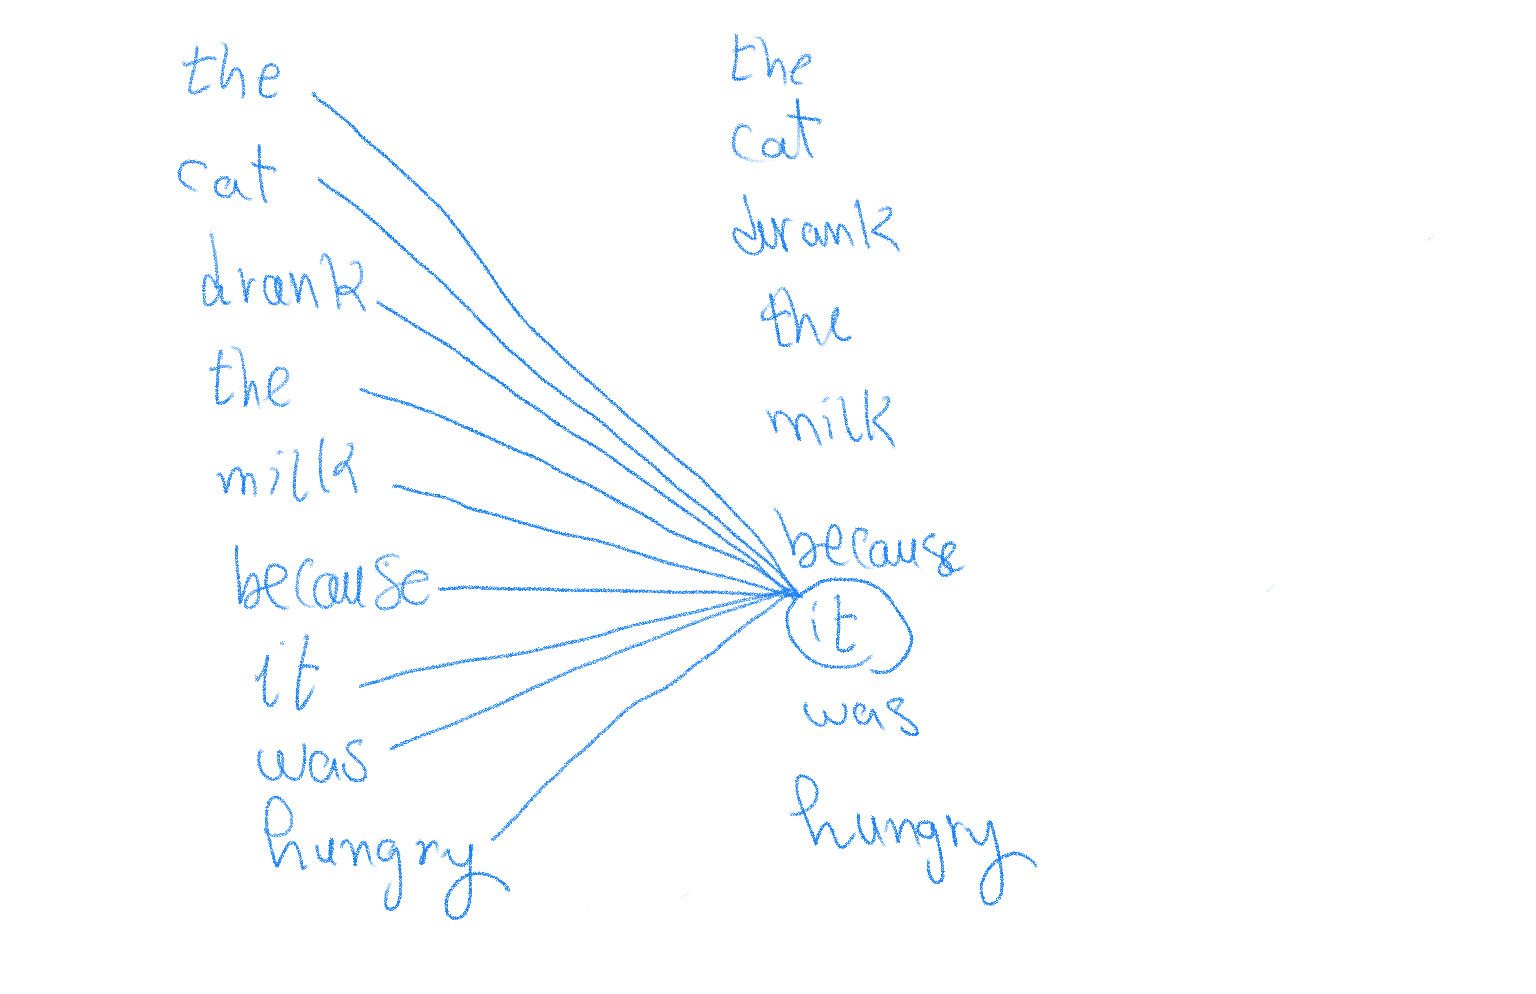

# Obviously this is too bad, can we do better?

## Unique weights for each word based on pairwise similairty

In [ ]:
word_it_idx = 6

word_it_orig_embed = embeddings[word_it_idx] # the embedding for the word it

attn = []
for i, embd in enumerate(embeddings): # Loop over all words
  attn.append(np.dot(word_it_orig_embed, embd)) # compute the similarity

print('attn scores\n', attn)
attn = softmax(attn)
print("Sum after softmax", np.sum(attn))

for i in range(len(data)):
  print(data[i], attn[i])

attn scores
 [42.140415, 22.166056, 23.493334, 42.140415, 21.987274, 38.00763, 43.595062, 38.605186, 24.359882]
Sum after softmax 1.0
the 0.15802377
cat 3.341707e-10
likes 1.2600794e-09
the 0.15802377
milk 2.7946312e-10
because 0.0025344074
it 0.6768114
was 0.0046067233
hungry 2.9973342e-09


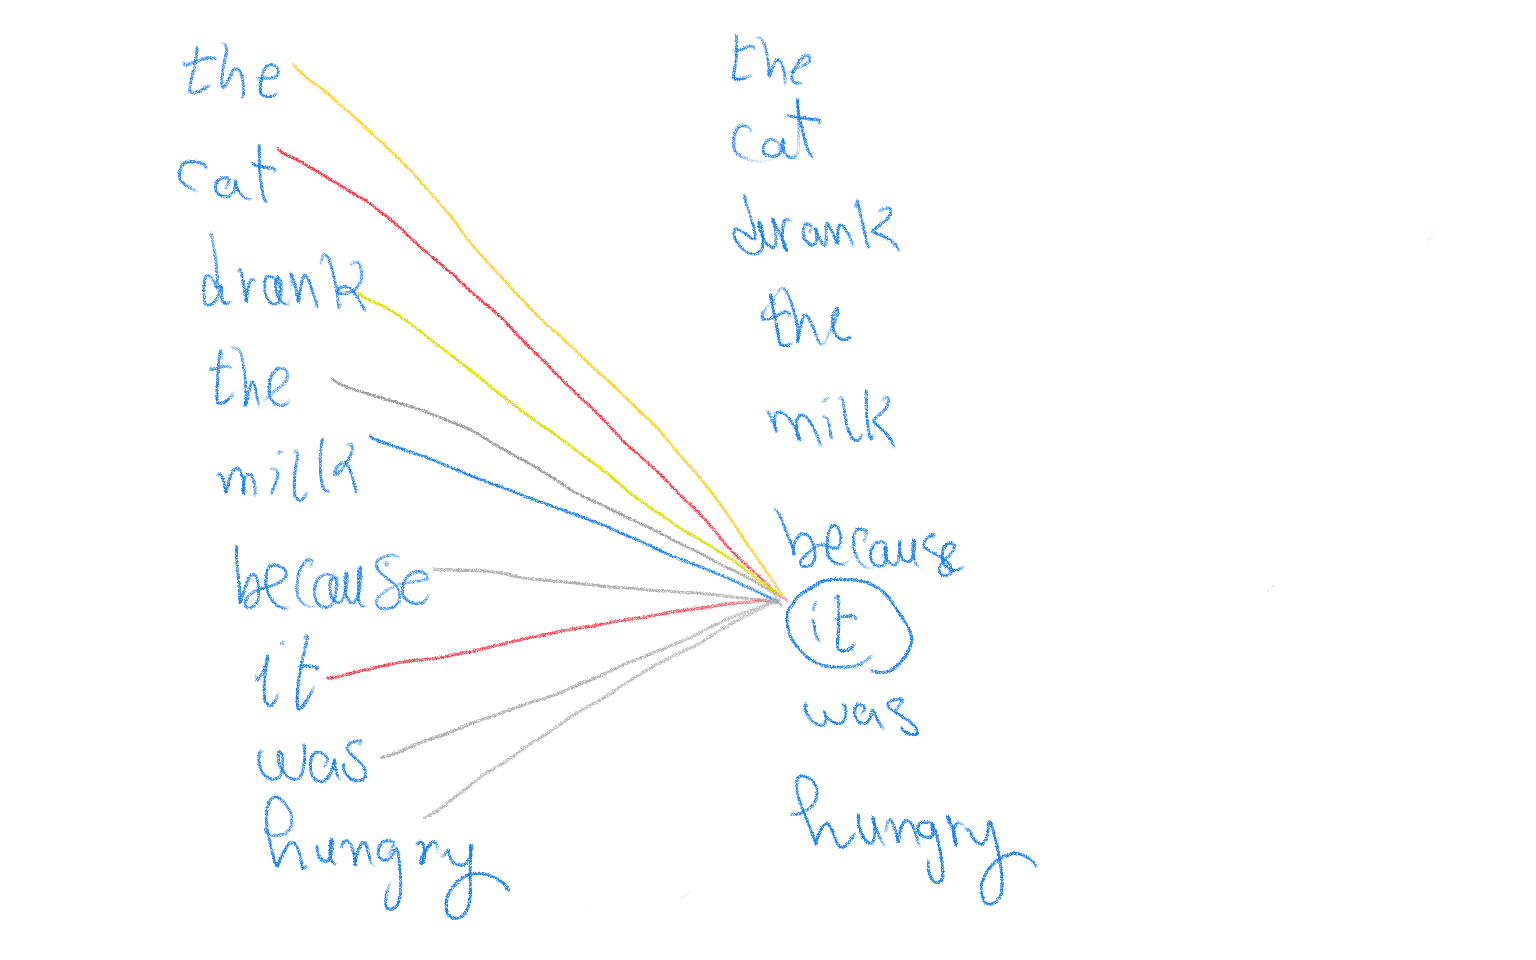

In [ ]:
weighted_avg_embeddings = np.zeros(25)
print("embeddings.shape", embeddings.shape)
for i, embd in enumerate(embeddings):
    weighted_avg_embeddings += embd * attn[i]

print(weighted_avg_embeddings)

embeddings.shape (9, 25)
[ 0.22058     0.24613     0.67961001  0.2475      0.44914001  0.10618
  0.73113    -0.20155001 -1.08879995 -0.67278999  0.16805001 -0.57441002
 -3.6407001  -1.36399996 -0.73041999  0.16029    -0.14656    -0.96743
  0.017693   -0.26187     0.55786002 -0.040442   -0.22627001 -0.0091492
 -1.00539994]


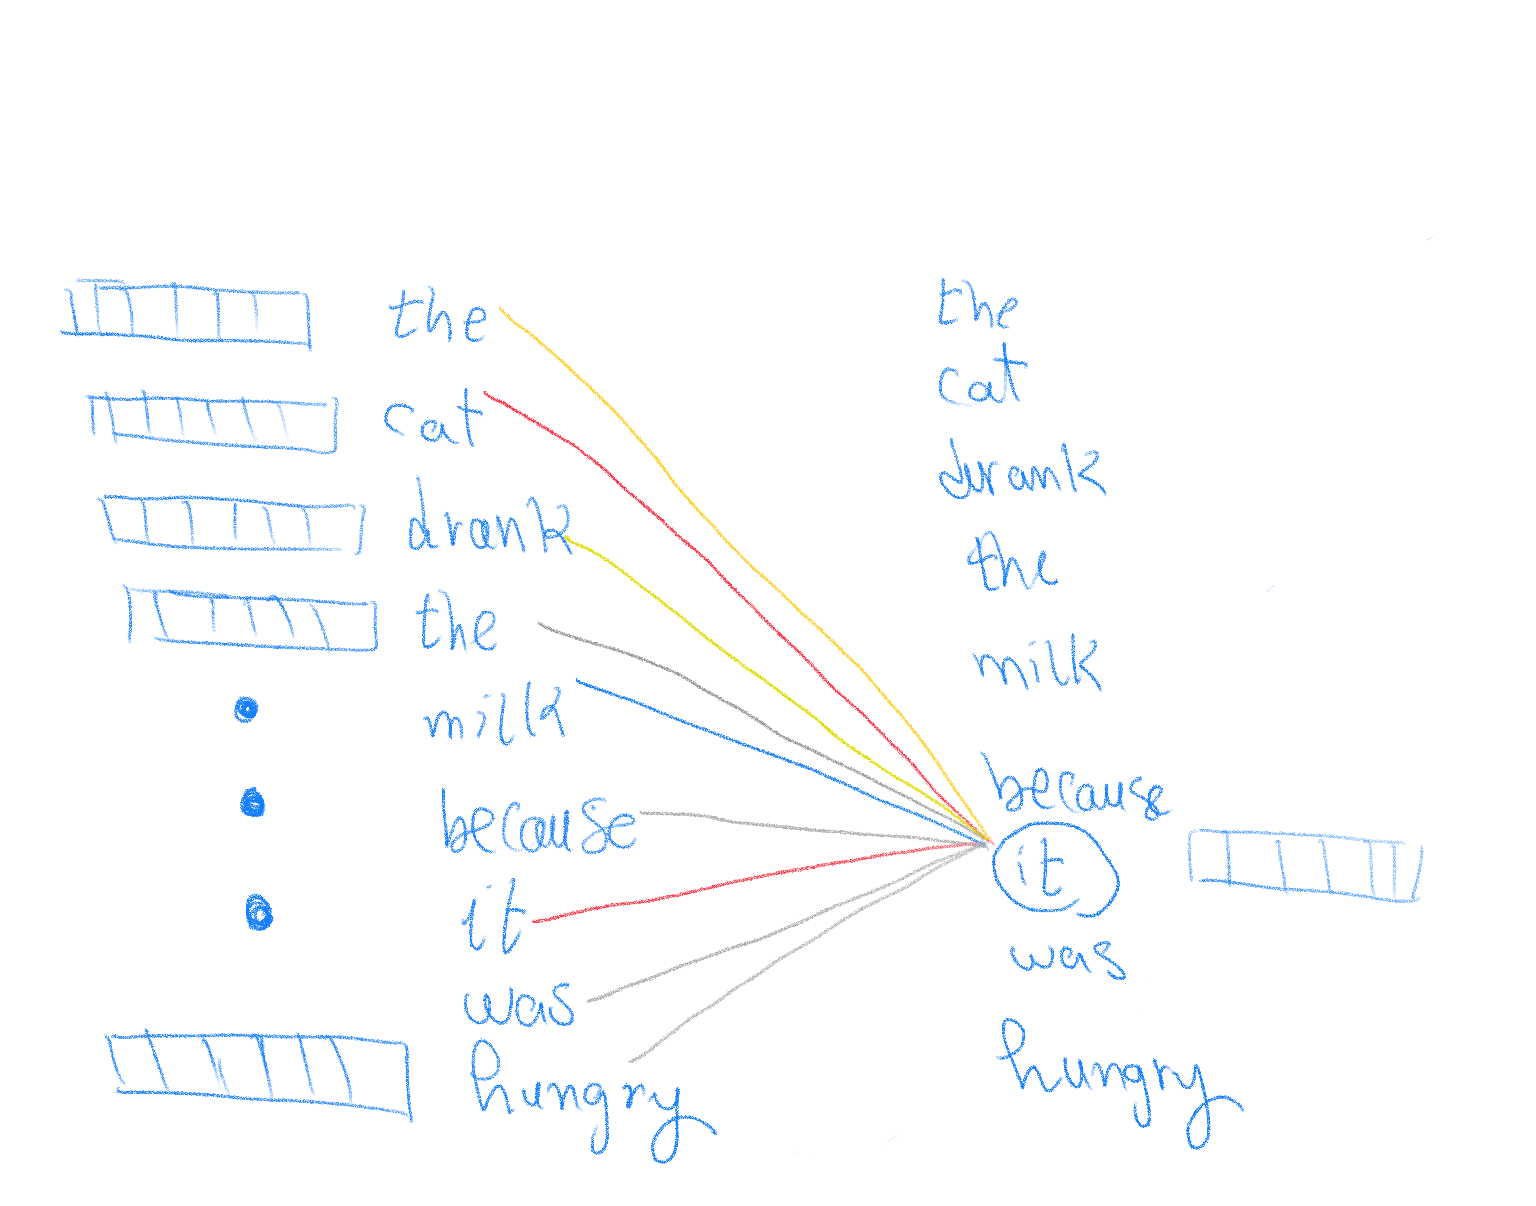

This still looks bad ... mainly because we are relying heavily on the original embedings
In another words there is no learning process here!

# Let's not worry how this matrix is generaetd

In [ ]:
WQ = np.random.rand(25, 32) # Q
WK = np.random.rand(25, 32) # K
WV = np.random.rand(25, 32) # V

# Generate new representation

In [ ]:
WQ.shape

(25, 32)

In [ ]:
embeddings.shape

(9, 25)

In [ ]:
Q = np.matmul(embeddings, WQ)
# embeddgins X WQ ===> 9*25 X 25*32 ... d  = 32
# Q.shape What is the shape

In [ ]:
Q.shape # 9 * 32

(9, 32)

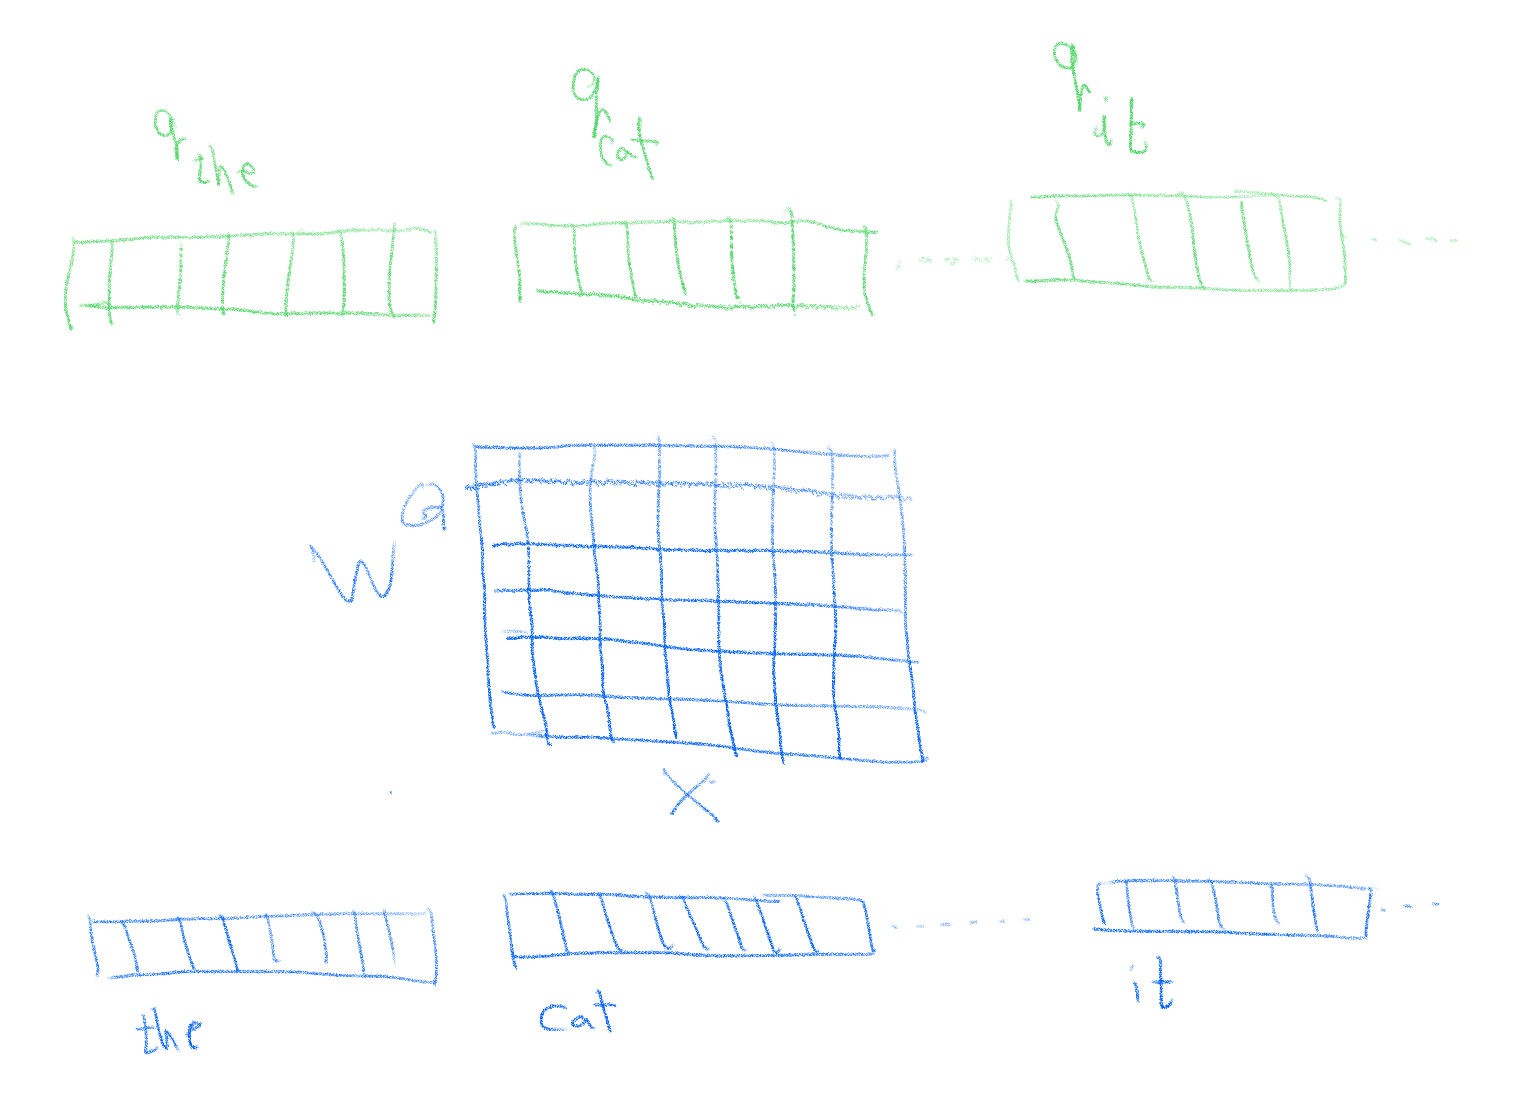

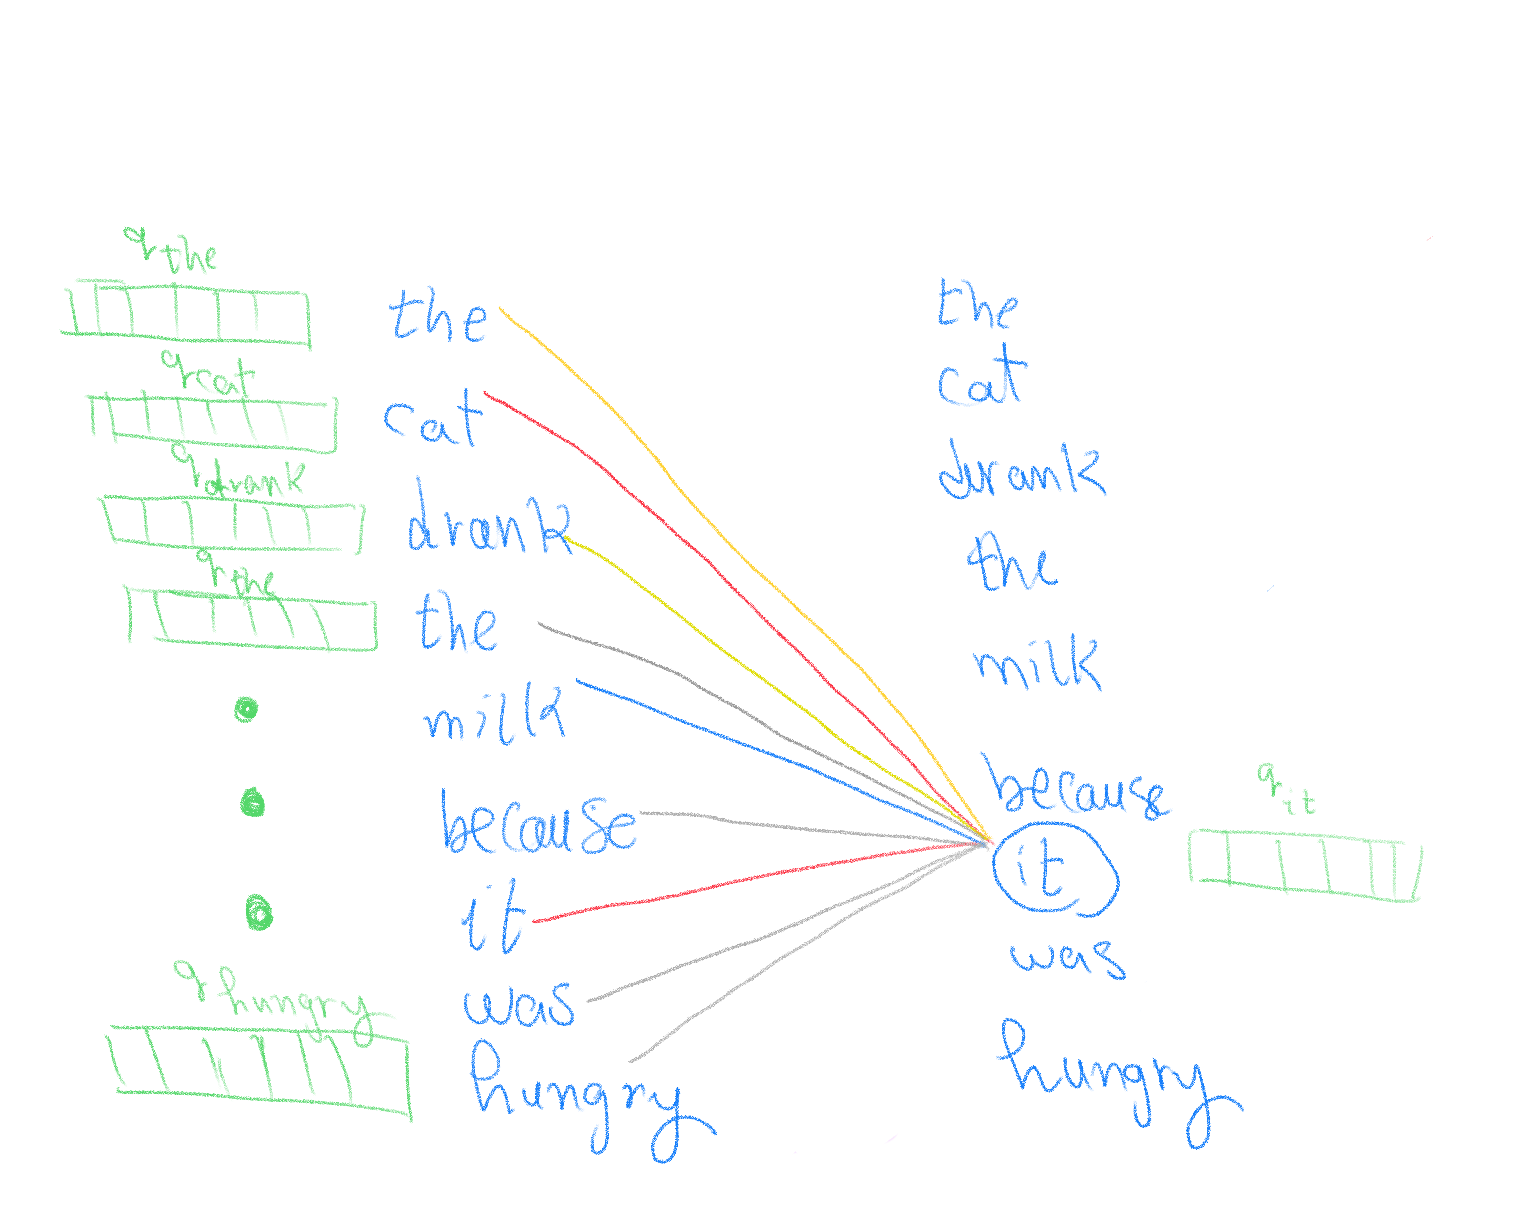

In [ ]:
print(word_it_idx)

6


In [ ]:
word_it_orig_embed = Q[word_it_idx]
attn = []
for i, q_i in enumerate(Q):
  attn.append(np.dot(word_it_orig_embed, q_i))
print('attn scores\n', attn)
attn = softmax(attn)
print('After softmax\n', attn)

attn scores
 [260.42955408961313, 102.55265635181455, 274.12659634772456, 260.42955408961313, 74.69903392552092, 254.18330141309588, 211.2688421040615, 126.23071907798948, 13.119696533733478]
After softmax
 [1.12576865e-006 3.06466947e-075 9.99997746e-001 1.12576865e-006
 2.45306537e-087 2.18140387e-009 5.02600838e-028 5.88349822e-065
 4.42733815e-114]


In [ ]:
weighted_avg_embeddings = np.zeros(Q.shape[1])
print("Initial value for weighted_avg_embeddings\n\n", weighted_avg_embeddings)
for (i, embd) in enumerate(Q):
  weighted_avg_embeddings += embd * attn[i]

print("\nFinal value for weighted_avg_embeddings\n\n", weighted_avg_embeddings)

Initial value for weighted_avg_embeddings

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

Final value for weighted_avg_embeddings

 [-1.36461435 -3.4462774  -4.65462076 -2.44088866 -3.45924675 -2.64974593
 -2.82292351 -2.53469644 -4.3838564  -5.67218283 -2.47858606 -3.71313229
 -1.64508507 -4.98290887 -2.41804118 -5.33875617 -4.7542503  -2.58713315
 -5.52967364 -4.56475648 -2.01675652 -6.39583594 -4.06199687 -4.07791544
 -5.25904573 -3.69171269 -4.9150303  -3.68321414 -4.08373378 -4.26516902
 -4.50273116 -2.90983411]


# There is still one problem with this

The cat like the milk because it was hungry

In [ ]:
print([(i, w) for i, w in enumerate(data)])

[(0, 'the'), (1, 'cat'), (2, 'likes'), (3, 'the'), (4, 'milk'), (5, 'because'), (6, 'it'), (7, 'was'), (8, 'hungry')]


In [ ]:
word_cat_idx = 1

In [ ]:
print('Attention that`it` should put on `cat` is', np.dot(Q[word_it_idx], Q[word_cat_idx]))
print('Attention that`cat` should put on `it` is', np.dot(Q[word_cat_idx], Q[word_it_idx]))

# print('Attention that`it` should put on `cat` is', np.dot(Q[6] + pos[6], Q[1] + p[1]))
# print('Attention that`cat` should put on `it` is', np.dot(Q[1] + pos[1], Q[6] + pos[6]))

Attention that`it` should put on `cat` is 102.55265635181455
Attention that`cat` should put on `it` is 102.55265635181455


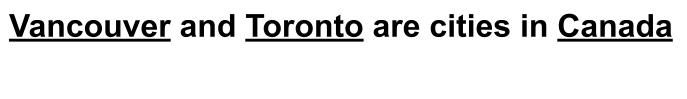

# How Much Attention do you expect from vancouver --> Canada and Toronto --> Canada

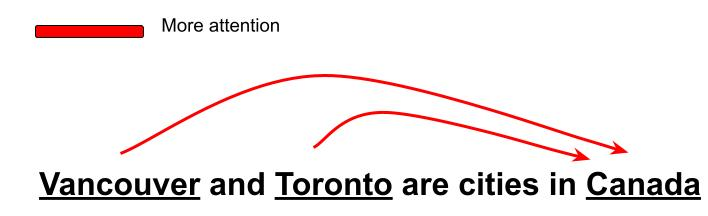

What about Canada --> Vancouver and Canada --> Toronto

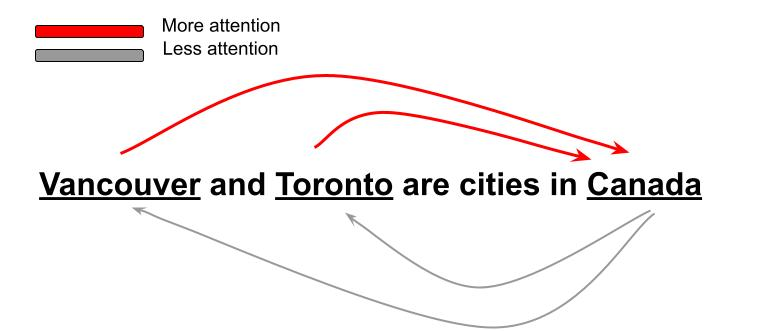

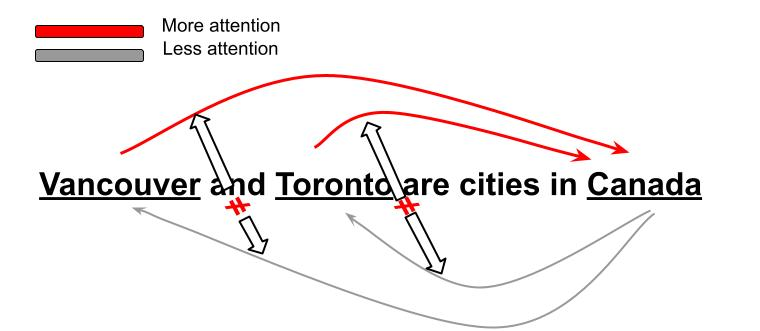

# So far Attention is Symmetric, how to make Assymetric?

In [ ]:
K = np.matmul(embeddings, WK)
print('WK.shape', WK.shape)
print('K.shape', K.shape)

WK.shape (25, 32)
K.shape (9, 32)


In [ ]:
print('Attention that`it` should put on `cat` is', np.dot(Q[6], K[1]))
print('Attention that`cat` should put on `it` is', np.dot(Q[1], K[6]))

Attention that`it` should put on `cat` is 64.1746914566537
Attention that`cat` should put on `it` is 64.33957451855622


In [ ]:
word_it_orig_embed = Q[word_it_idx] # green ... for the word it
attn = []
for i, embd in enumerate(K): # red
  attn.append(np.dot(word_it_orig_embed, embd))
print('attn scores\n', attn)
attn = softmax(attn)
print('After softmax', attn)

attn scores
 [190.22112999351435, 93.12865411453822, 246.58735544596834, 190.22112999351435, 64.65667483176684, 192.18639924682353, 125.80291489891285, 75.56682916578904, 9.443482168463431]
After softmax [3.31481519e-025 2.25804614e-067 1.00000000e+000 3.31481519e-025
 9.73888686e-080 2.36572856e-024 3.49932251e-053 5.33002375e-075
 1.02264387e-103]


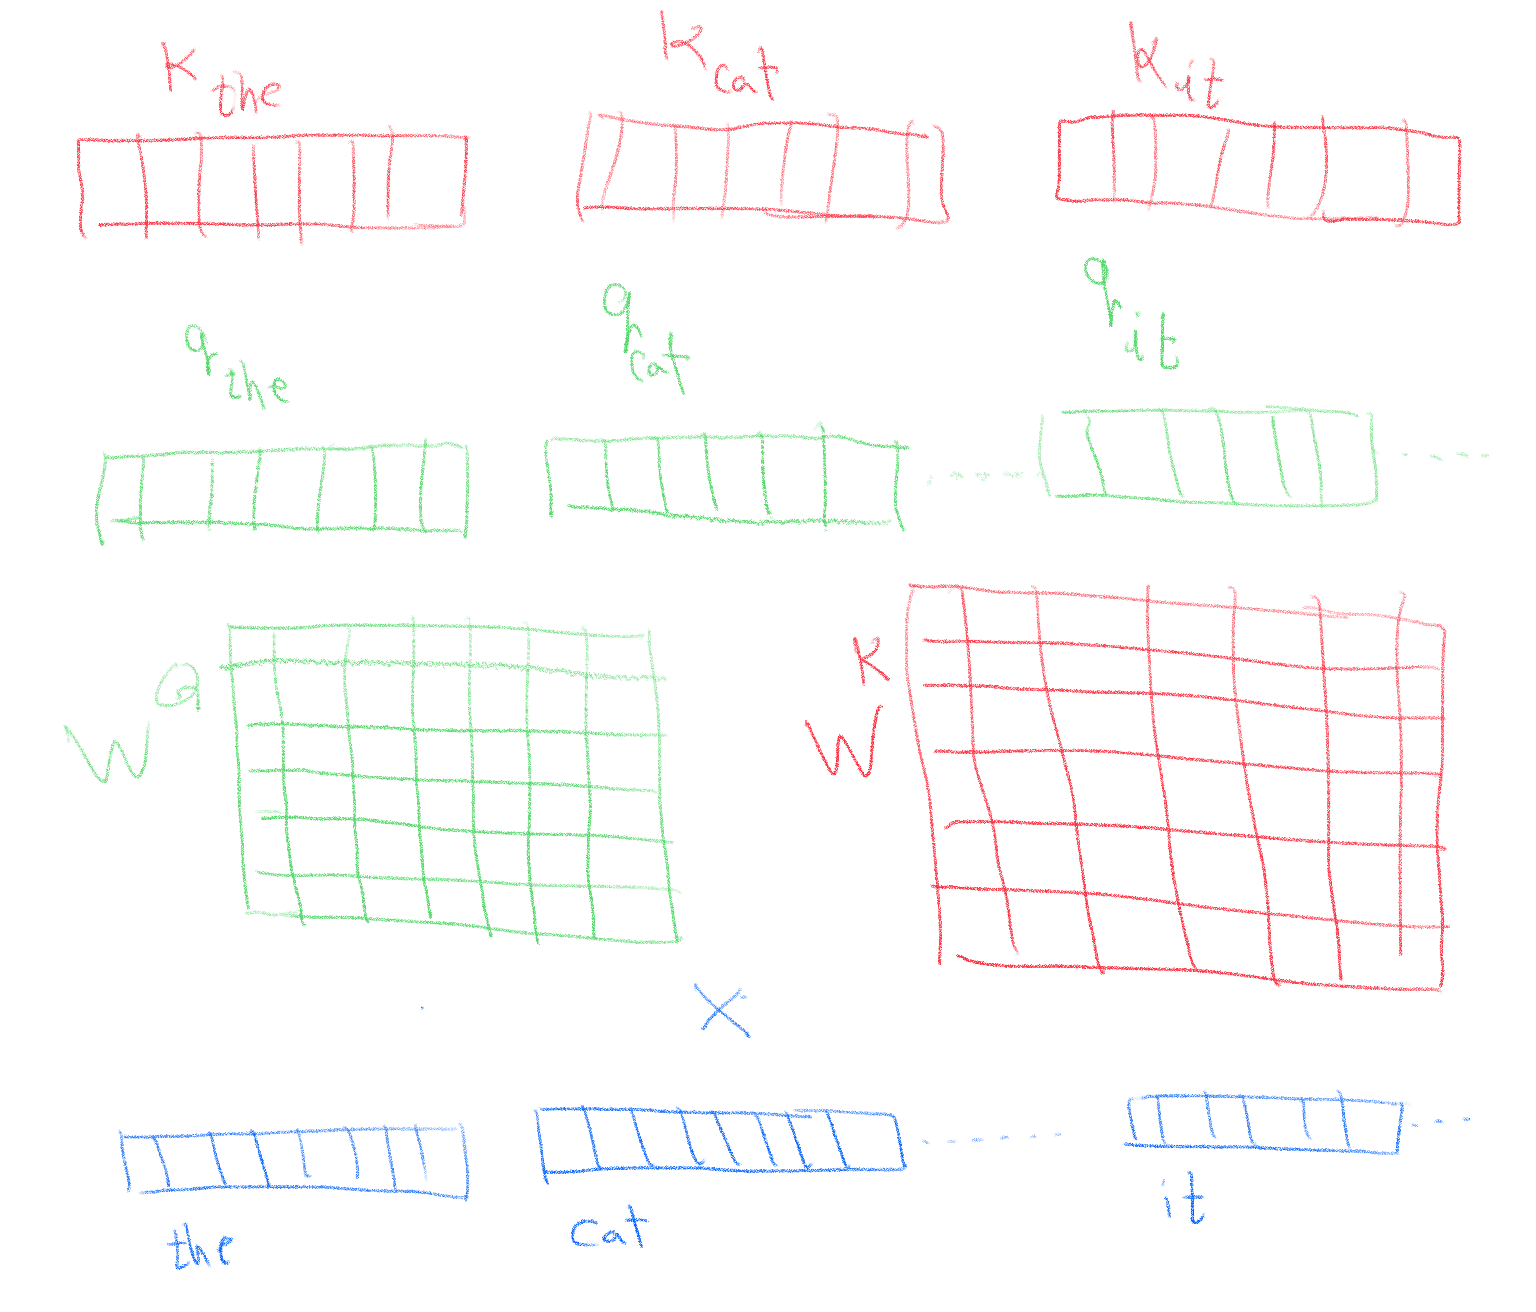

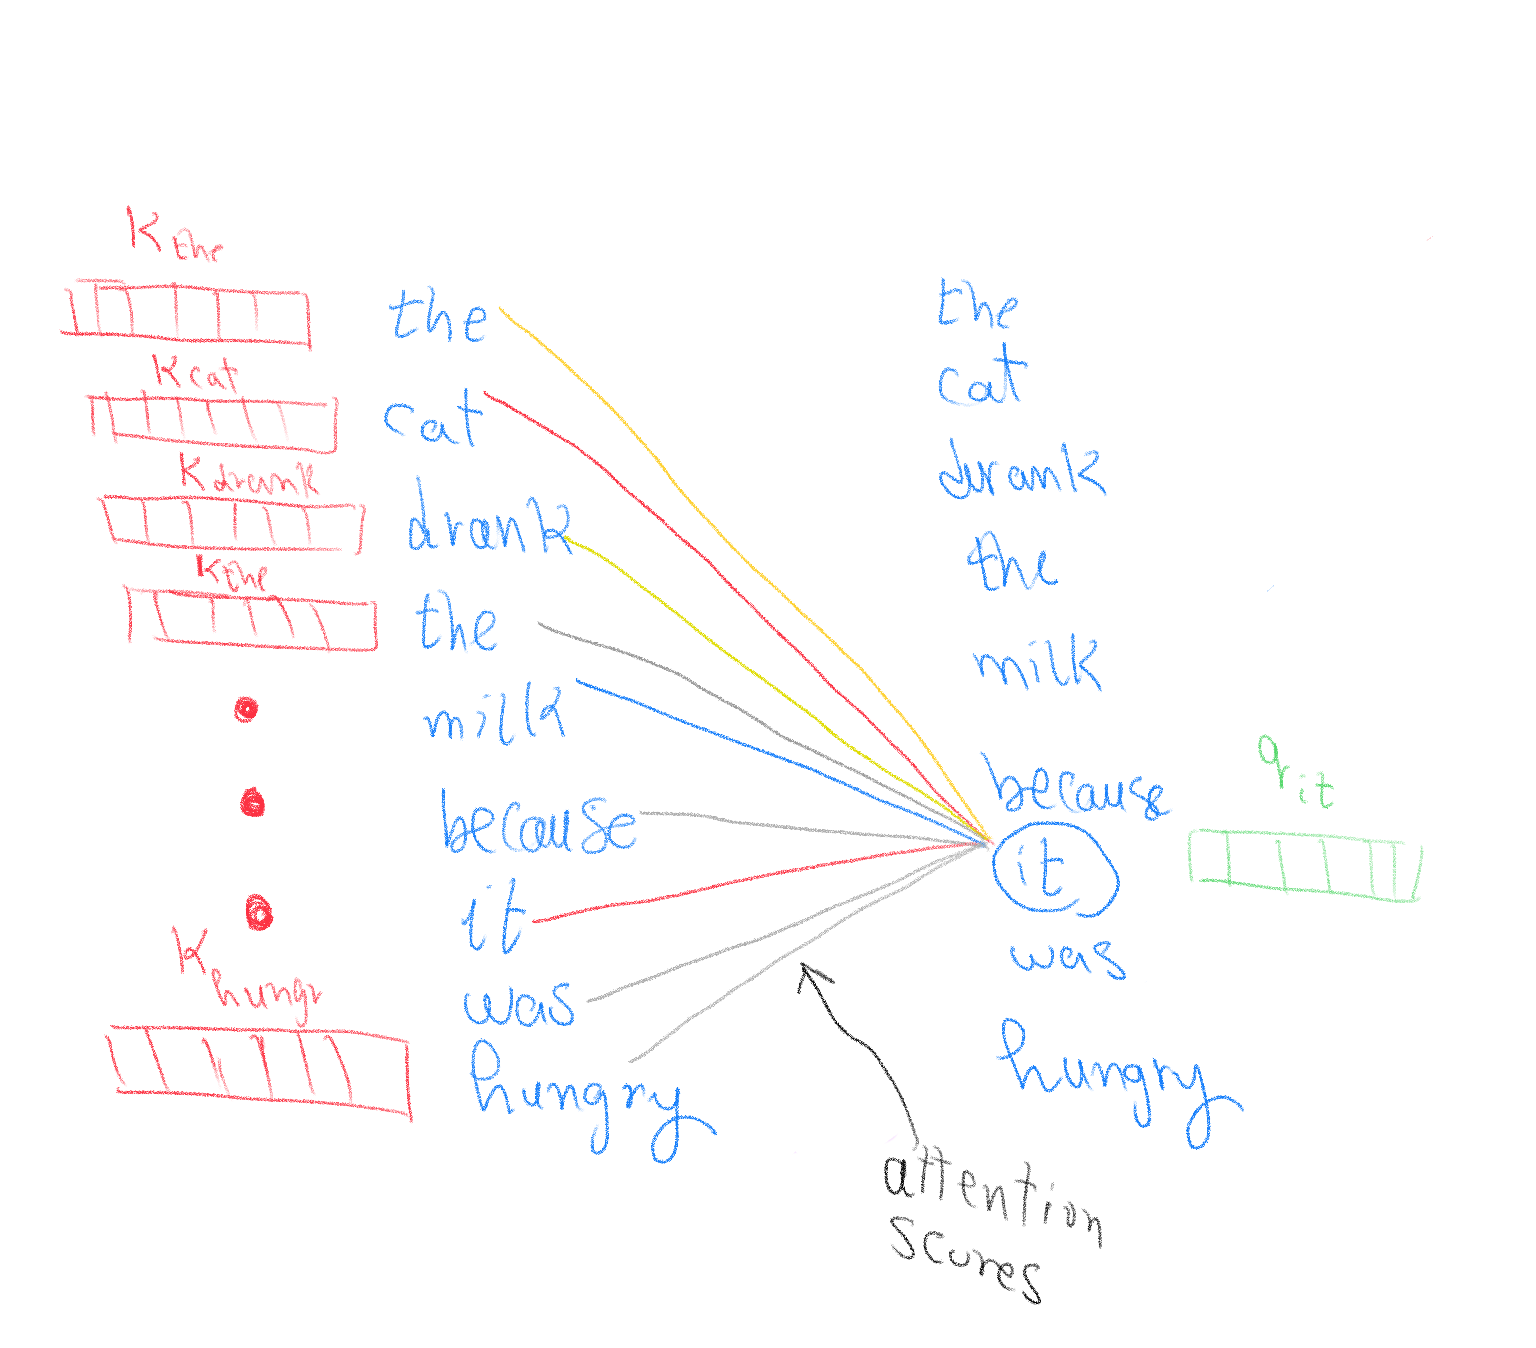

In [ ]:
K_weighted_avg_embeddings = np.zeros(K.shape[1])
print(K_weighted_avg_embeddings)
for (i, k_i) in enumerate(K):
  K_weighted_avg_embeddings += k_i * attn[i]

print(K_weighted_avg_embeddings)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[-2.52377131 -3.10772445 -4.68065177 -4.42821426 -2.77334226 -4.25528802
 -3.62050631 -3.8052219  -4.03252169 -4.21373641 -5.47980002 -5.6865289
 -2.06028958 -4.69711672 -3.38815524 -3.47579795 -3.30535063 -5.11536091
 -3.1765735  -2.17230733 -3.12625779 -5.09631474 -2.85664921 -5.89648563
 -4.73547272 -5.81017111 -5.87435354 -4.70546677 -2.81263371 -2.38867814
 -1.33342688 -1.87795244]


In [ ]:
Q_weighted_avg_embeddings = np.zeros(Q.shape[1])
print(Q_weighted_avg_embeddings)
for (i, q_i) in enumerate(Q):
  Q_weighted_avg_embeddings += q_i * attn[i]

print(Q_weighted_avg_embeddings)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.36461487 -3.44628061 -4.65462242 -2.44088886 -3.45925322 -2.64974969
 -2.82293046 -2.53470386 -4.38385671 -5.67218668 -2.47858666 -3.71312814
 -1.64508423 -4.98290778 -2.41804686 -5.33875603 -4.7542522  -2.58713798
 -5.52967972 -4.5647625  -2.0167569  -6.39583722 -4.0620003  -4.07791386
 -5.25904984 -3.69171919 -4.91502868 -3.68322243 -4.08373286 -4.26516963
 -4.50273405 -2.90983681]


# How are these WQ and WK are being generated?

# Let's Give the Attention Mechanism More Parameters to Learn

In [ ]:
V = np.matmul(embeddings, WV)
# print('WV.shape', WV.shape) # ... ??
# print('V.shape', V.shape) # ...??

In [ ]:
print('WV.shape', WV.shape)
print('V.shape', V.shape)

WV.shape (25, 32)
V.shape (9, 32)


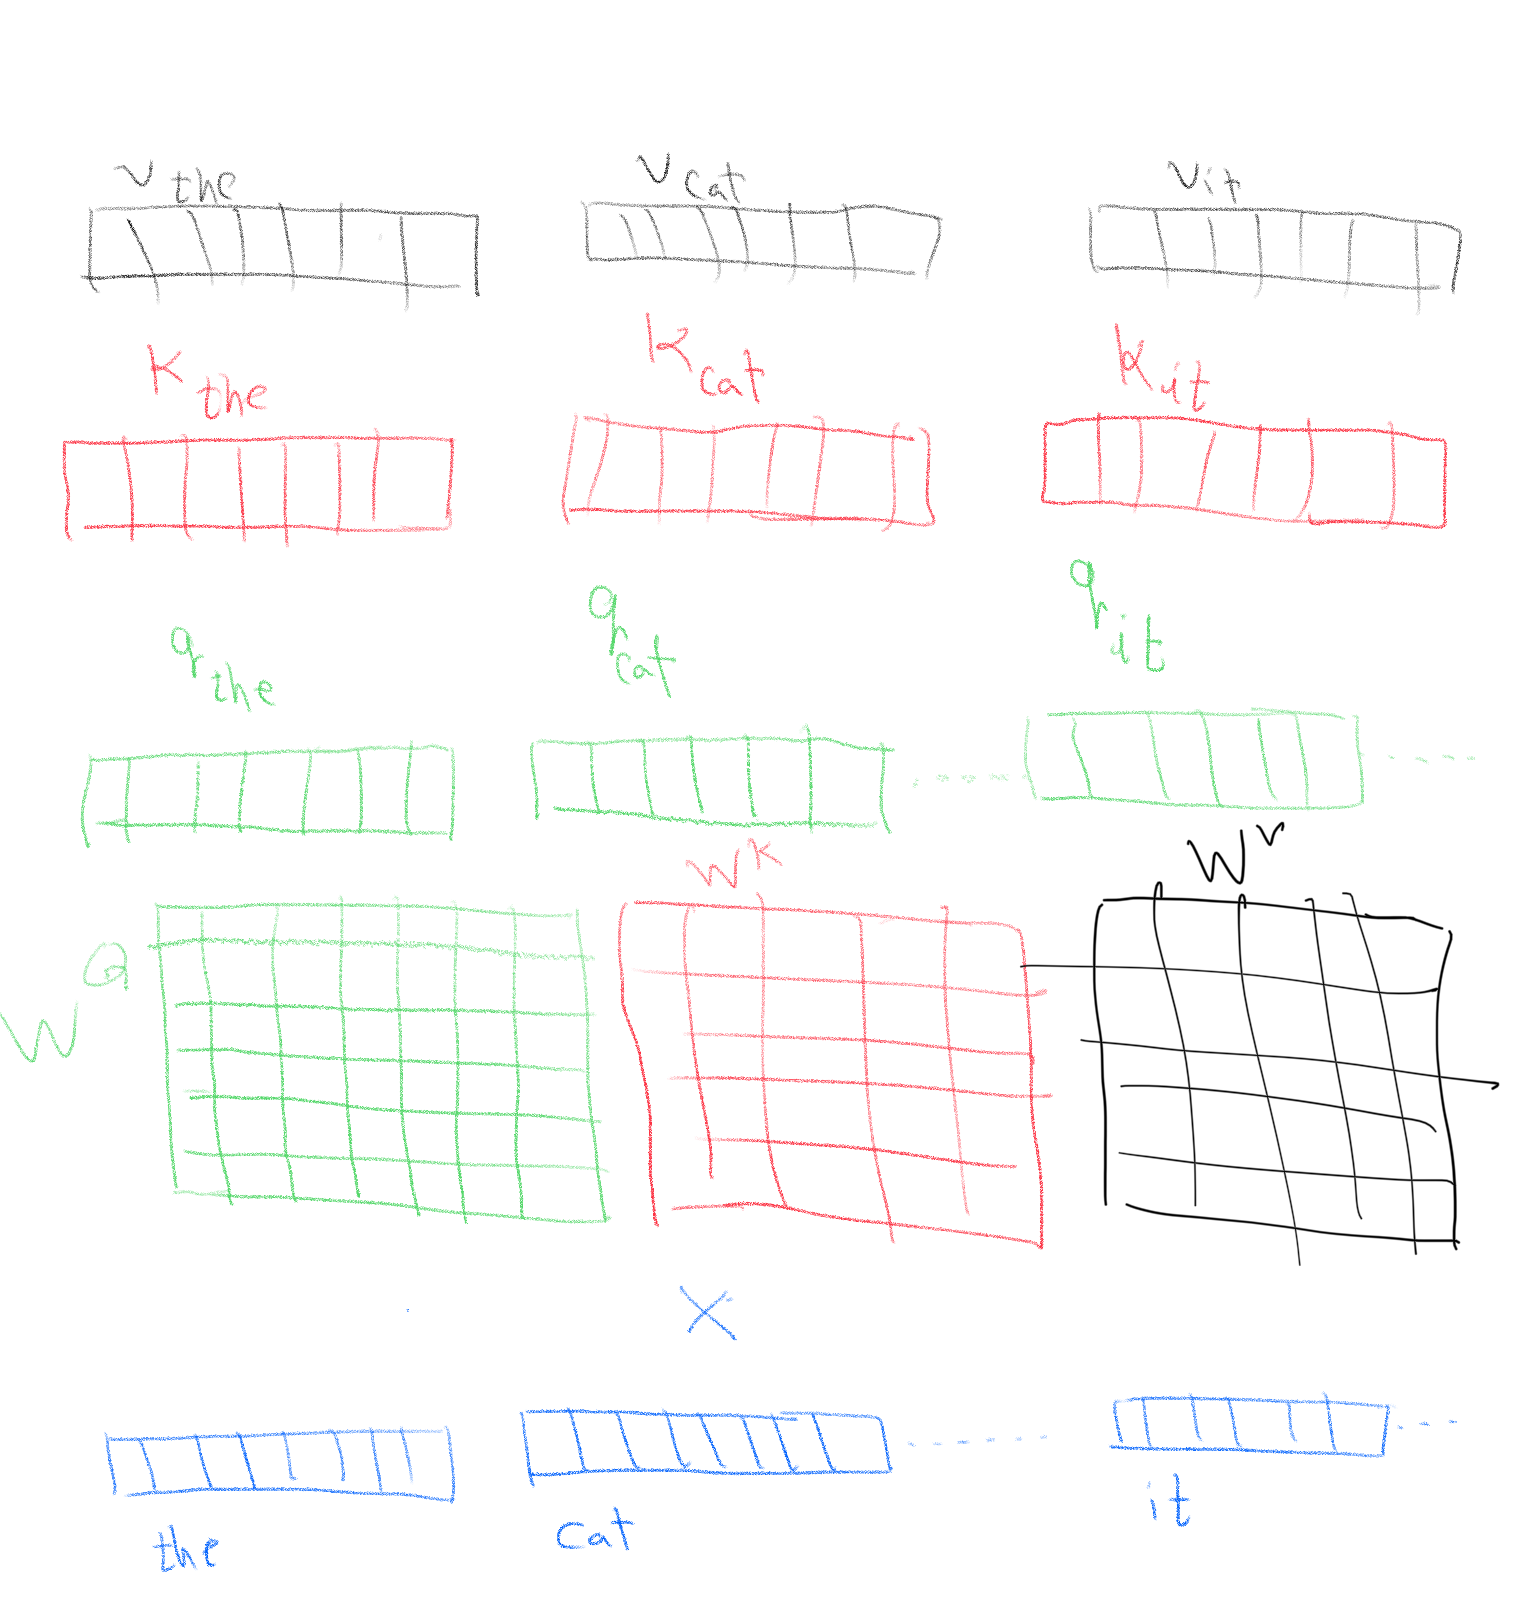

In [ ]:
attn

array([1.03164281e-022, 7.80825630e-075, 1.00000000e+000, 1.03164281e-022,
       1.89059163e-086, 4.44375184e-020, 9.77149505e-045, 2.50342388e-080,
       7.98297484e-107])

In [ ]:
v_weighted_avg_embeddings = np.zeros(Q.shape[1])
print(v_weighted_avg_embeddings)
for i in range(V.shape[0]):
  v_weighted_avg_embeddings += V[i] * attn[i]

print(v_weighted_avg_embeddings)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[-3.15630749 -3.33213283 -2.0625526  -3.57684679 -4.23360292 -4.08745568
 -3.92627641 -4.18655438 -2.43718972 -2.966682   -2.45669517 -3.86432303
 -3.03770477 -6.61842245 -2.99651675 -6.15163624 -3.75527487 -2.86692282
 -3.92783468 -5.95487871 -4.13020059 -2.07837682 -2.13128089 -4.92963138
 -2.79485912 -1.84035007 -3.90153494 -0.88487704 -4.91963954 -4.24787964
 -2.42141591 -3.10502367]


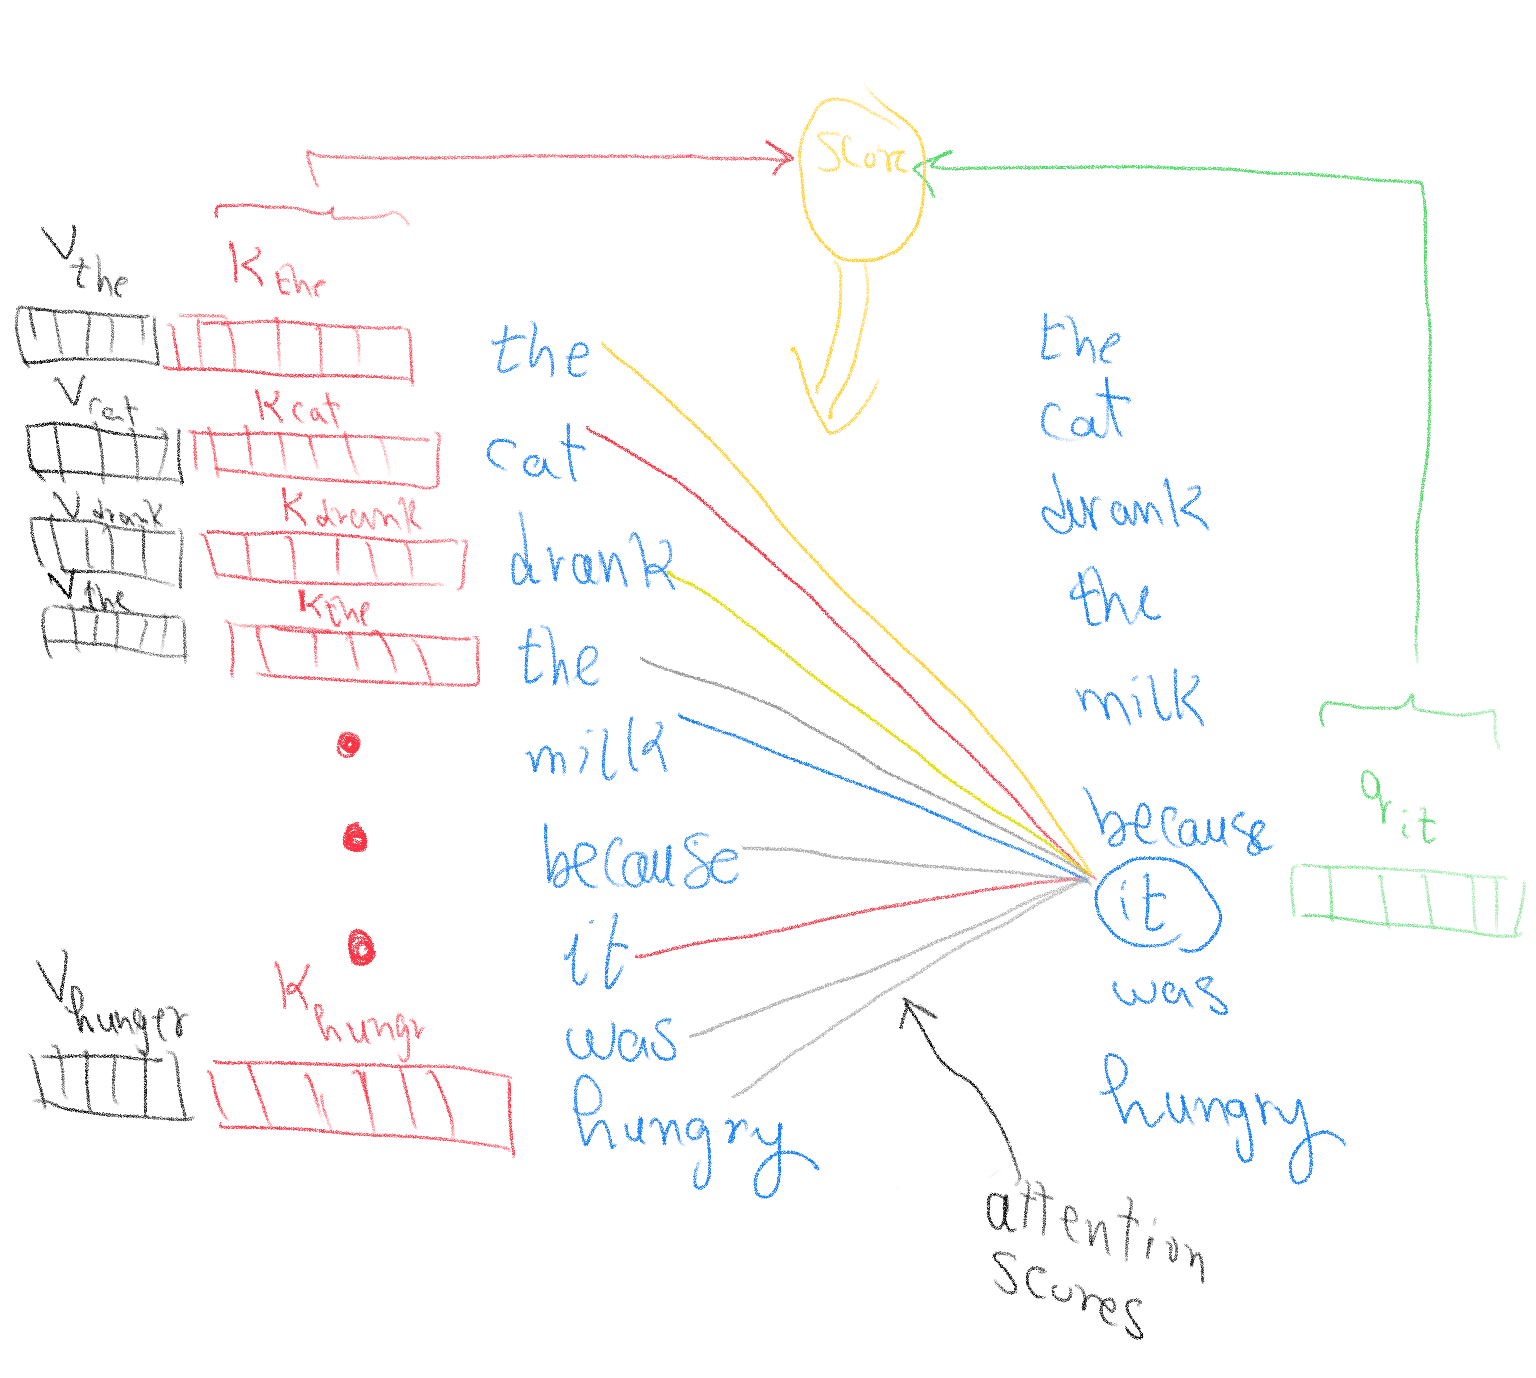

# Let's build these as matrices

## Attention for each word:


In [ ]:
orig_embed = Q[6]
attn = []
for i, embd in enumerate(K):
  attn.append(np.dot(orig_embed, embd))
print('attn scores\n', attn)
attn = softmax(attn)
print('After softmax', attn)

attn scores
 [184.18767220843048, 64.1746914566537, 234.8133917566994, 184.18767220843048, 37.4279635688188, 190.2531889254841, 133.4765320505792, 51.52424366490394, -9.485902065166595]
After softmax [1.03164281e-022 7.80825630e-075 1.00000000e+000 1.03164281e-022
 1.89059163e-086 4.44375184e-020 9.77149505e-045 2.50342388e-080
 7.98297484e-107]


## Attenion for all words

In [ ]:
print(Q.shape)
print(K.shape)

(9, 32)
(9, 32)


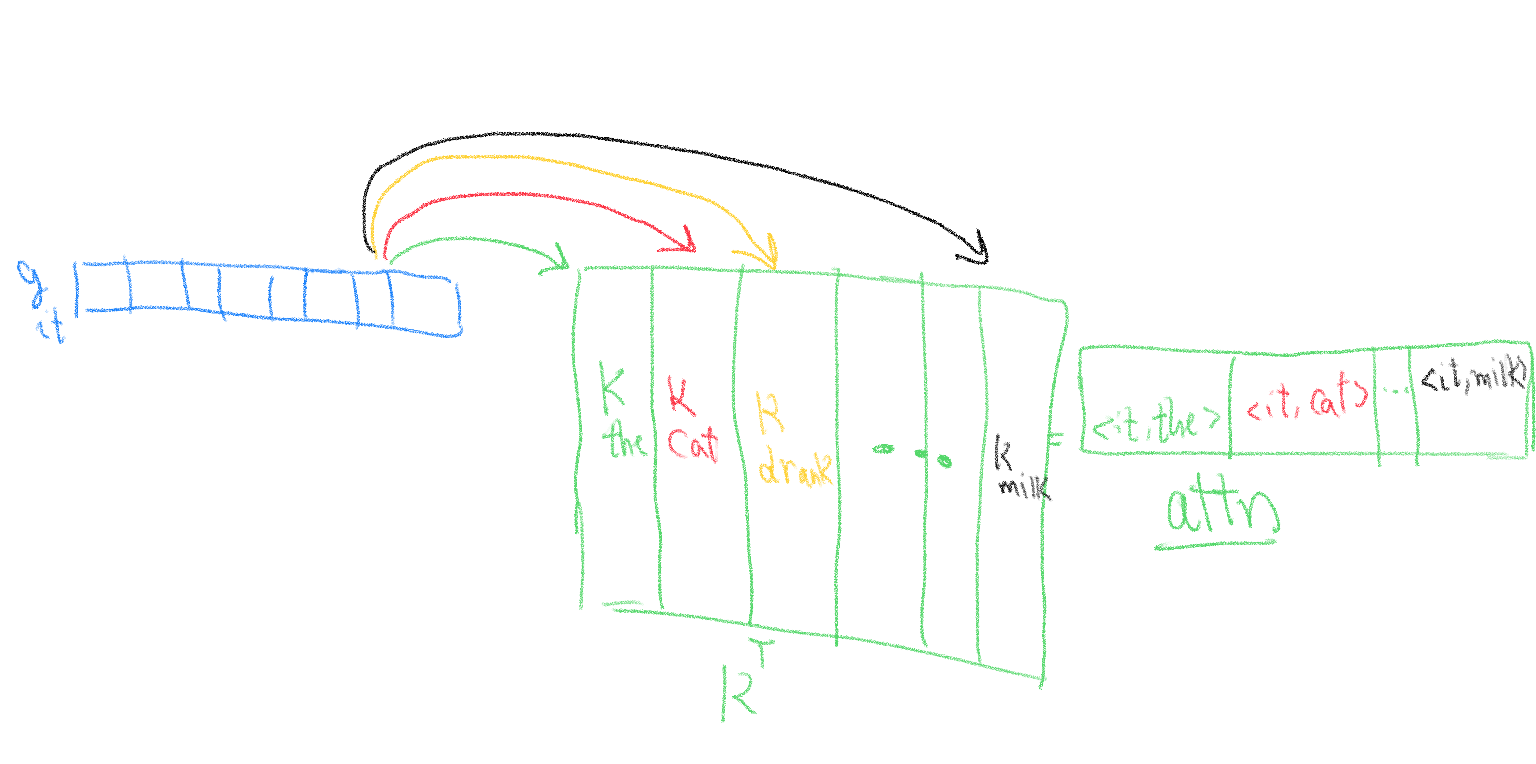

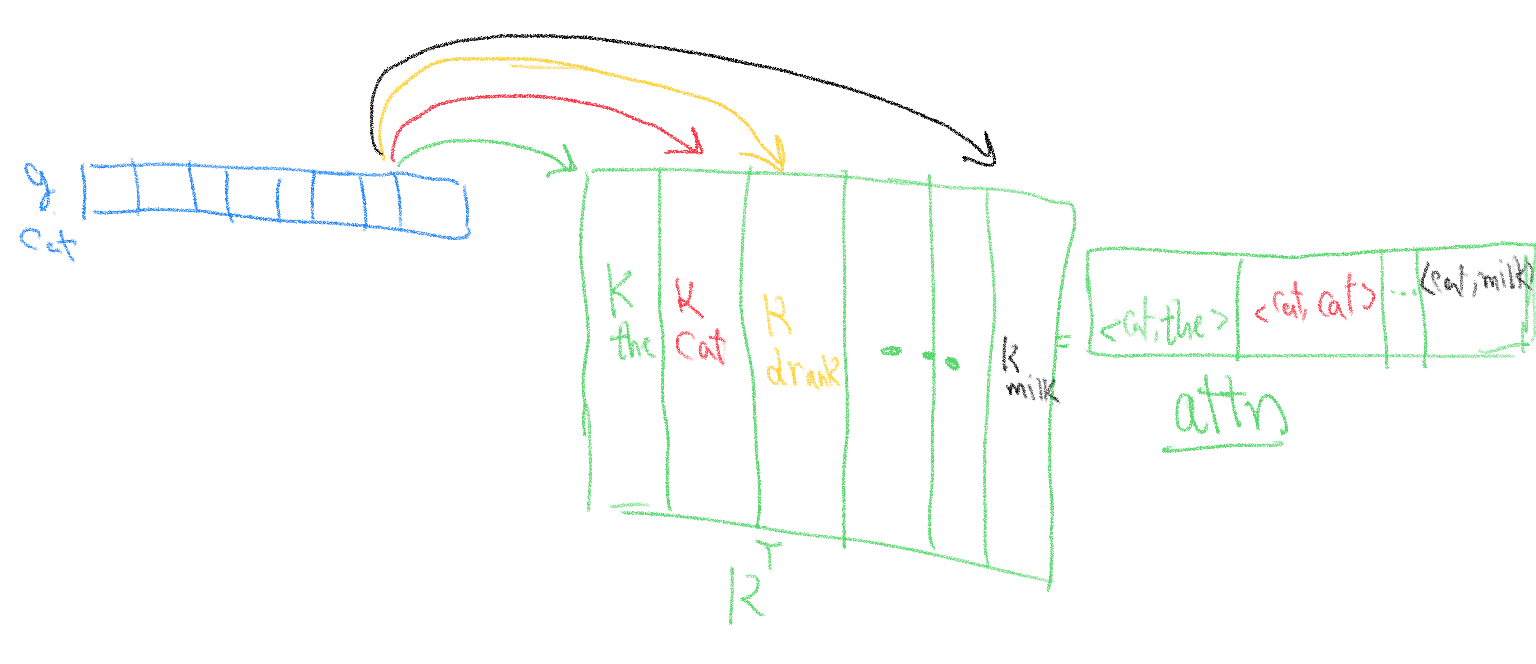

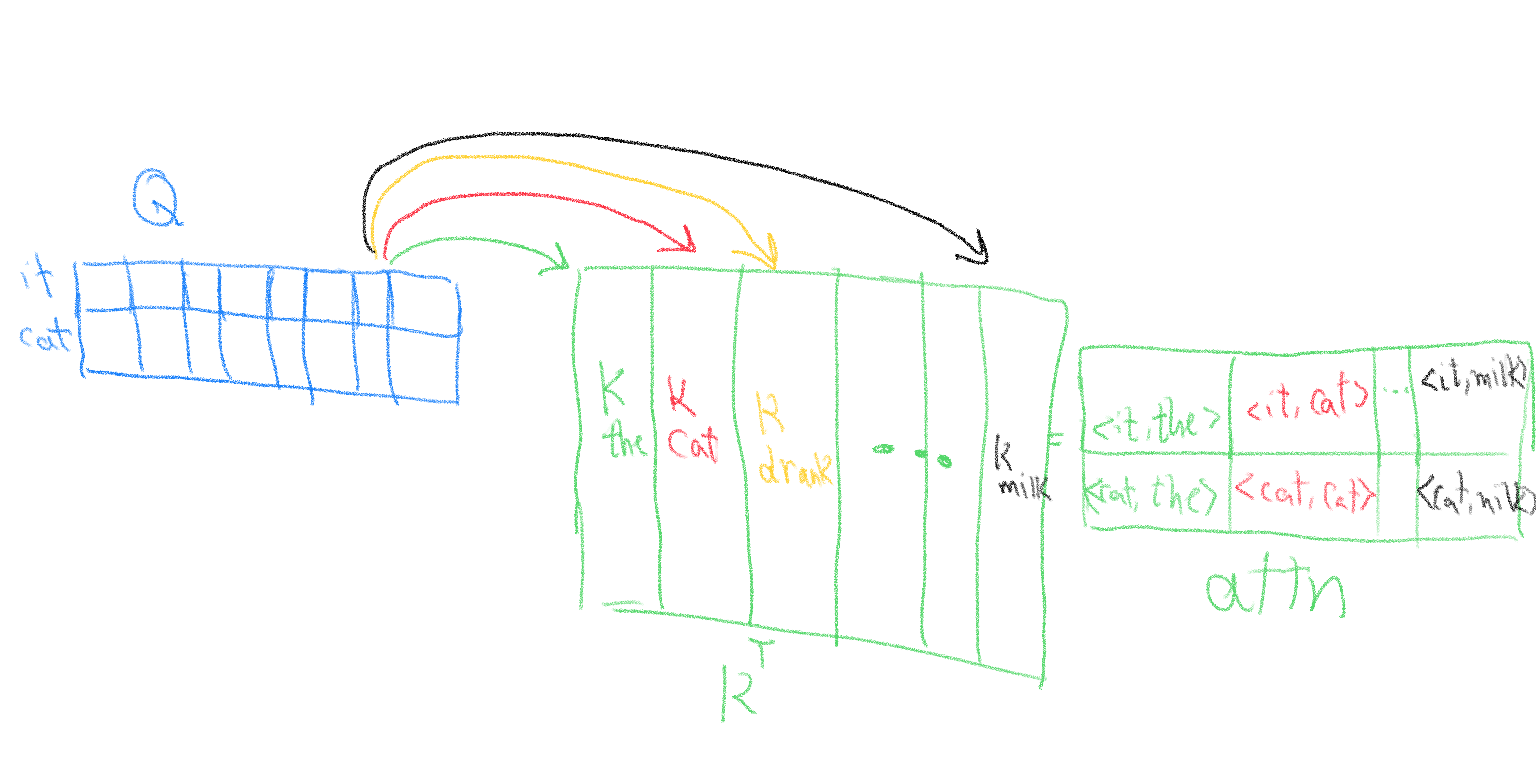

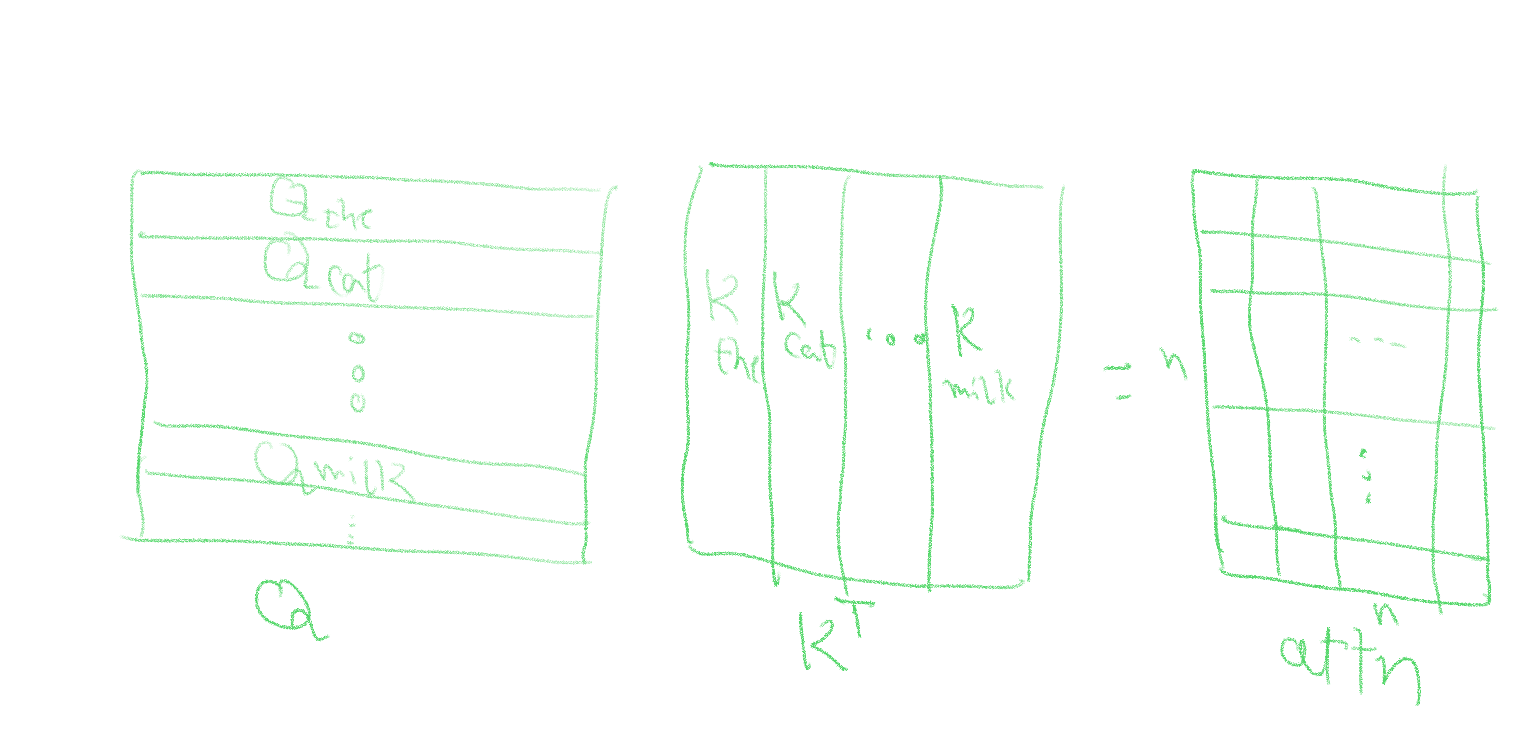

In [ ]:
print(Q.shape)
print(K.shape)

(9, 32)
(9, 32)


In [ ]:
attn_all = np.matmul(Q, K.T)
print(attn_all.shape)

(9, 9)


## Final Representation for each word

In [ ]:
avg_embeddings = np.zeros(Q.shape[1])
for i in range(K.shape[0]):
  avg_embeddings += V[i] * attn[i]

In [ ]:
print(WV.shape)
print(V.shape)

# 9*9 X 9 * 32 ==> 9*32

(25, 32)
(9, 32)


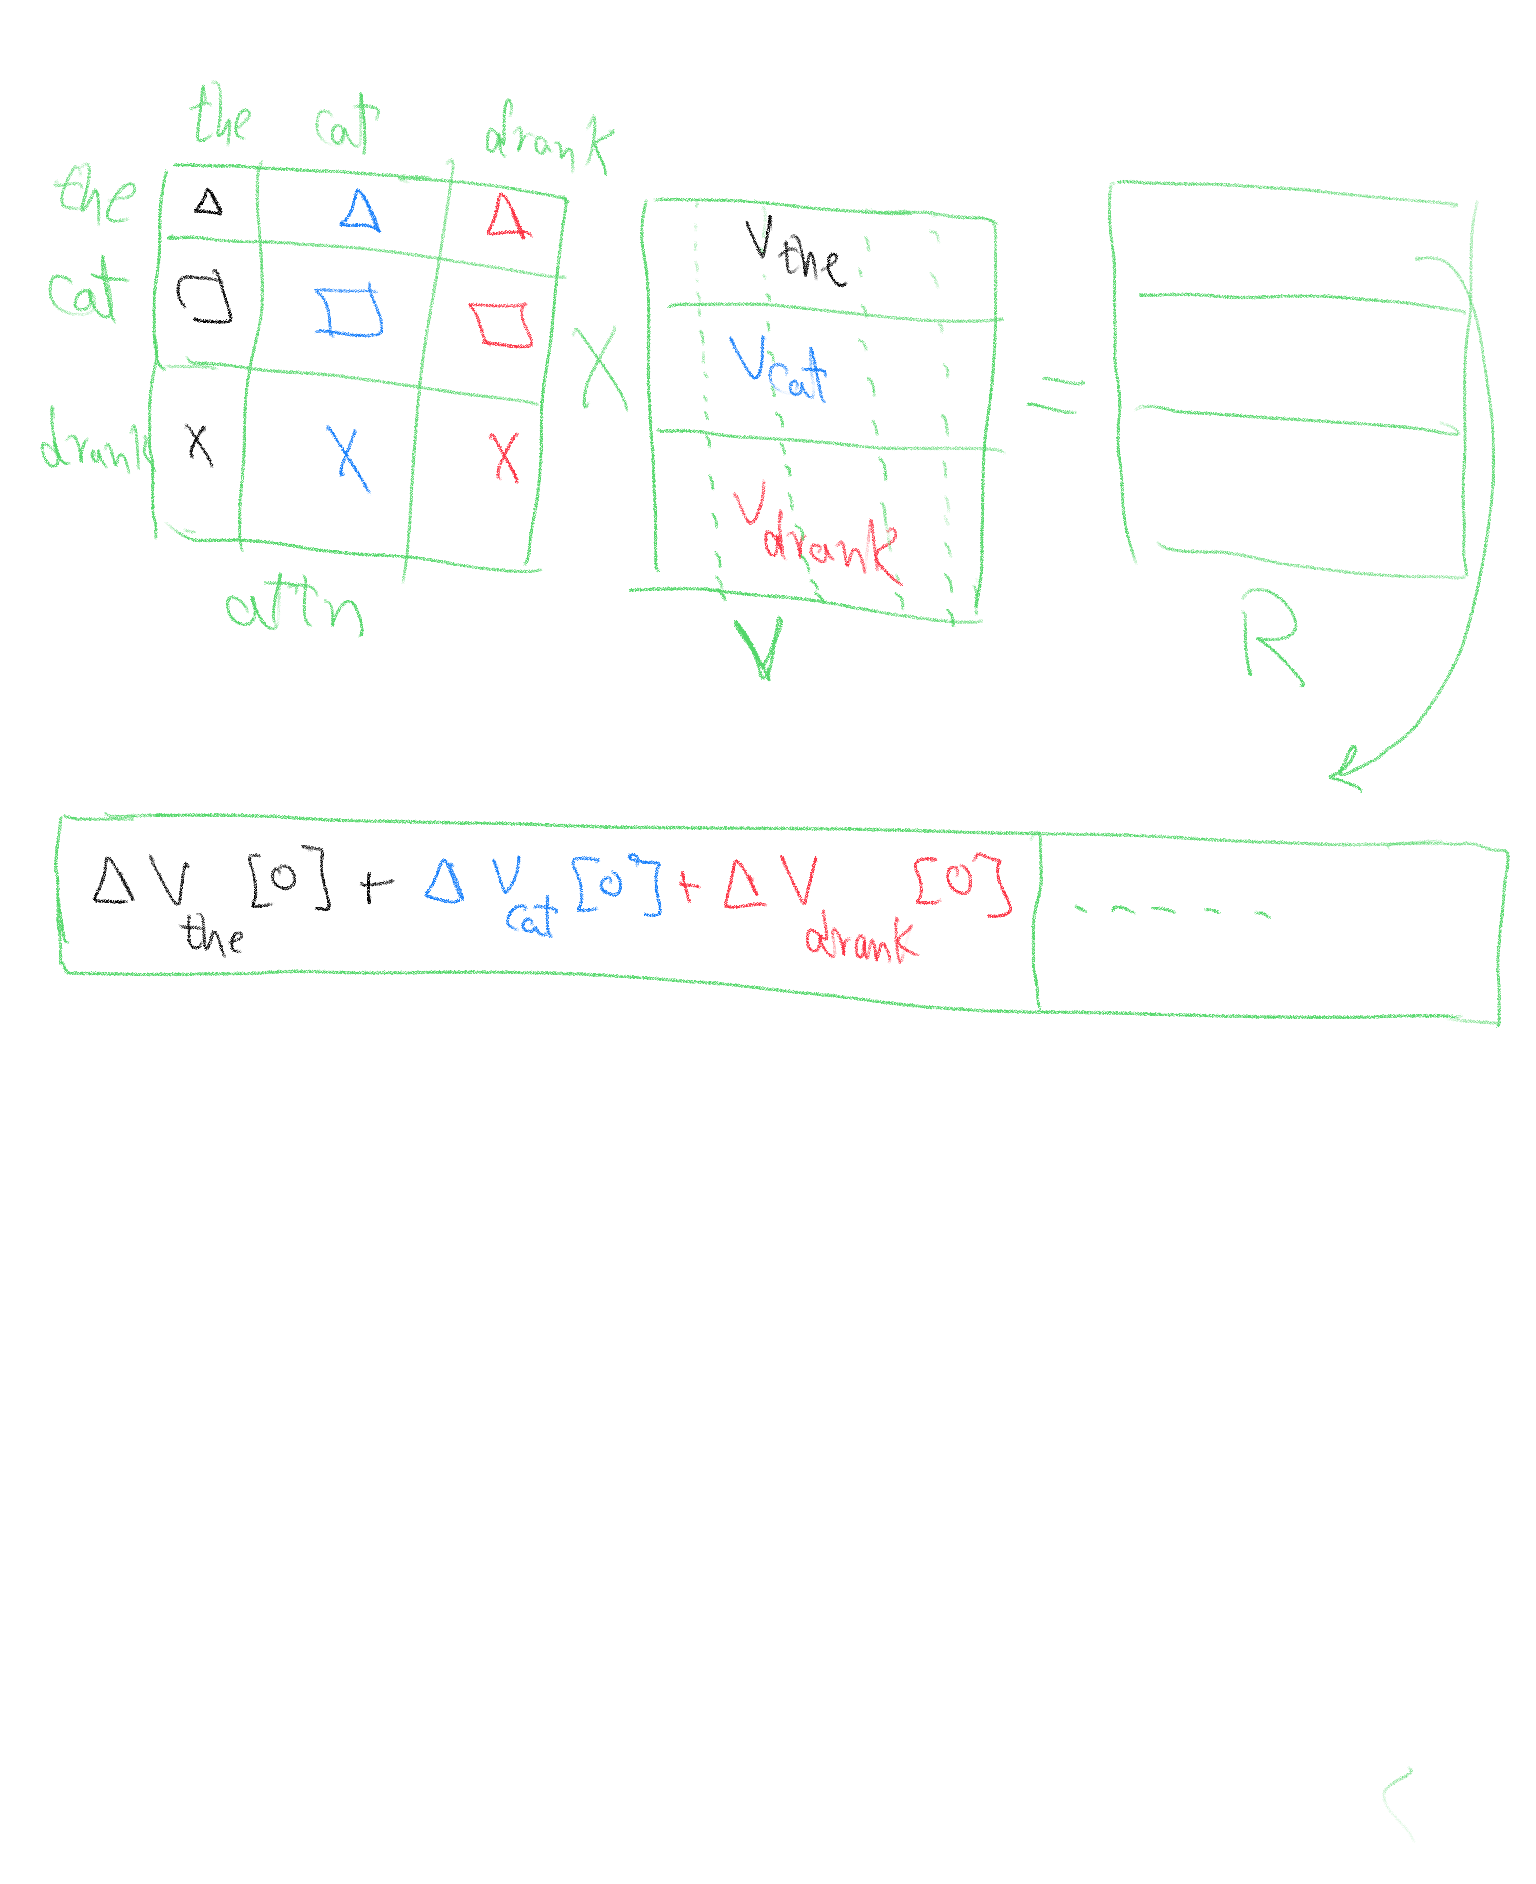

In [ ]:
final_rep = np.matmul(attn_all, V)
print(final_rep.shape)

(9, 32)
